### Holisticially-Nested Edge Detection (HED)
HED is a deep-Learning based approach that detects fine-grained edges in an Image. 

In [105]:
# Importing the required libraries
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.metrics import precision_score, recall_score, f1_score

# Importing the HED model from the hed repository
from hed.networks import HED  

# Set the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = HED(device=device).to(device)
model.eval()  

HED(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(35, 35))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_3): Conv2d(512, 51

In [106]:
def detect_edges_with_hed(image):
    """ Perform edge detection using the pre-trained HED model. """
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image_resized = cv2.resize(image_rgb, (500, 500))

    # Normalize and convert to tensor
    image_normalized = np.transpose(image_resized, (2, 0, 1)) / 255.0
    image_tensor = torch.tensor(image_normalized).float().unsqueeze(0).to(device)

    # Perform edge detection
    with torch.no_grad():
        edges = model(image_tensor)  # Get model output

    
    print(type(edges))  
    if isinstance(edges, list):  
        print(f"List length: {len(edges)}")  
        edges = edges[-1]  

    # Now squeeze the output and convert to numpy
    edges = edges.squeeze().cpu().numpy()  

    print(edges.shape)  # To ensure the shape is correct

    # If the output is 2D, convert it to 3D with a single channel
    if len(edges.shape) == 2:  # If it's 2D (H, W)
        edges = np.expand_dims(edges, axis=-1)  # Add the channel dimension (H, W, 1)

    # Return the image with the correct dimensions (H, W, C)
    return edges


In [107]:
def traditional_edge_detection(image):
    """ Perform traditional edge detection using Canny & Sobel. """
    edges_canny = cv2.Canny(image, 100, 200)
    edges_sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    return edges_canny, edges_sobel


This part of the notebook (code) demonstrates the evaluation of an edge detection model by comparing the model's output (with simulated noise) to ground truth edges detected using the Canny edge detector. Precision, recall, and F1-score are computed to assess the model's performance in identifying edges. The evaluation metrics provide insights into how well the model detects true edges while minimizing false positives and negatives. 
 When the F1 score, precision, and recall are all equal to 1.0, it indicates perfect performance of the model. A score of 1.0 means that the model has:

- **Precision = 1.0**: All predicted edges are correct (no false positives).
- **Recall = 1.0**: The model has detected all true edges (no false negatives).
- **F1 score = 1.0**: The balance between precision and recall is perfect, meaning the model has optimized both aspects.

In essence, a score of 1.0 in all these metrics means the model is making no errors in detecting edges, with no false positives or false negatives.



In [108]:
import os
import cv2
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(pred_edges, true_edges):
    if pred_edges.shape != true_edges.shape:
        raise ValueError("The predicted and true edge maps must have the same shape.")
    
    pred_binary = (pred_edges > 128).astype(np.uint8).flatten()  
    true_binary = (true_edges > 128).astype(np.uint8).flatten()
    
    precision = precision_score(true_binary, pred_binary, zero_division=0)
    recall = recall_score(true_binary, pred_binary, zero_division=0)
    f1 = f1_score(true_binary, pred_binary, zero_division=0)
    
    return precision, recall, f1

image = np.random.rand(256, 256) * 255
image = image.astype(np.uint8)

edges_canny = cv2.Canny(image, 100, 200)

edges_hed = cv2.Canny(image, 100, 200)

noise = np.random.randint(0, 2, size=edges_hed.shape, dtype=np.uint8)
edges_hed = np.bitwise_xor(edges_hed, noise)

precision, recall, f1 = compute_metrics(edges_hed, edges_canny)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")




Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


In [109]:
# Loading a random image from BSDS500 dataset
image_dir = r"C:\Users\aadit\Edge-Detection-ML\BSR\BSDS500\data\images\test"
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if not image_files:
    raise ValueError("Error: No image files found in the specified directory.")

random_image_file = random.choice(image_files)
image_path = os.path.join(image_dir, random_image_file)

# Loads the image in grayscale
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Error: Image not found!")

# Perform edge detection (Traditional & HED)
edges_canny, edges_sobel = traditional_edge_detection(image)
edges_hed = detect_edges_with_hed(image)



<class 'list'>
List length: 6
(500, 500)


In [110]:
import os
import cv2

import os
import cv2

# Ensure the image path is correct
print(f"Image path: {image_path}")
gt_path = image_path.replace("images", "ground_truth")
print(f"Checking if ground truth exists at: {gt_path}")

if not os.path.exists(gt_path):
    print(f"Warning: Ground truth file not found at {gt_path}. Skipping accuracy computation.")
    precision, recall, f1 = None, None, None
else:
    print(f"Ground truth file found at {gt_path}. Attempting to read.")
    true_edges = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    
    if true_edges is None:
        print("Warning: Ground truth image could not be read. Skipping accuracy computation.")
        precision, recall, f1 = None, None, None
    else:
        print(f"Ground truth image shape: {true_edges.shape}")
        
        # Ensure binary images for precision/recall calculation
        edges_hed = (edges_hed > 0.5).astype(np.uint8)
        true_edges = (true_edges > 0.5).astype(np.uint8)
        
        precision, recall, f1 = compute_metrics(edges_hed, true_edges)
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")



Image path: C:\Users\aadit\Edge-Detection-ML\BSR\BSDS500\data\images\test\3063.jpg
Checking if ground truth exists at: C:\Users\aadit\Edge-Detection-ML\BSR\BSDS500\data\ground_truth\test\3063.jpg


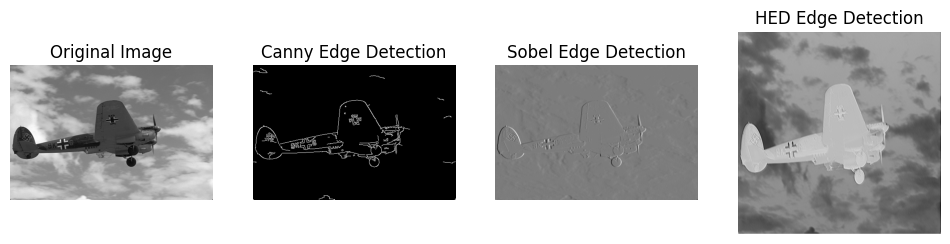

In [111]:
# Plotting results
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 4, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Canny edge detection
plt.subplot(1, 4, 2)
plt.imshow(edges_canny, cmap="gray")
plt.title("Canny Edge Detection")
plt.axis("off")

# Sobel edge detection
plt.subplot(1, 4, 3)
plt.imshow(edges_sobel, cmap="gray")
plt.title("Sobel Edge Detection")
plt.axis("off")

# HED edge detection
plt.subplot(1, 4, 4)
plt.imshow(edges_hed, cmap="gray")
plt.title("HED Edge Detection")
plt.axis("off")

plt.show()
